# Prototyping for fmrs/1_two_peak_simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Models
### Spectral model
Original is sum of two Gaussian lineshapes, but modify to be lorentzian for simple FSL fitting model.

First replicate paper's only real representation, then generate using complex FSL-MRS tools.

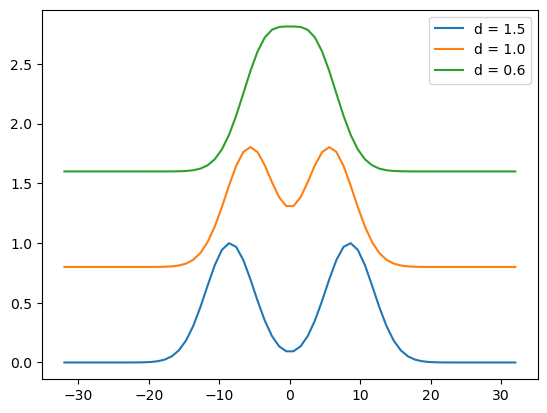

In [2]:
spectral_width = 64
points = 64
frequency_axis = np.linspace(-spectral_width/2, spectral_width/2, points)

fwhm = 8
delta = fwhm / 2.355

# Eqn 2 in A. Tal, 10.1002/mrm.29456
def gaussian_peak(nu, a, mu, Delta):
    return a * np.exp(-(nu - mu) **2 / (2 * Delta **2))

# Eqn 1 in A. Tal, 10.1002/mrm.29456
def spectrum(f_axis, amplitude, frequency, damping):
    return gaussian_peak(f_axis, amplitude[0], frequency[0], damping[0])\
         + gaussian_peak(f_axis, amplitude[1], frequency[1], damping[1])


# Equivalent to Eqn 5 in A. Tal, 10.1002/mrm.29456
def separations(d):
    separation = d * np.sqrt(2) * 8
    return (-separation/2, separation/2)
    
# Test by recreating Figure 2A
for idx, d_val in enumerate([1.5, 1.0, 0.6]):
    test_spec = spectrum(
        frequency_axis,
        (1.0, 1.0),
        separations(d_val),
        (delta, delta))

    plt.plot(frequency_axis, test_spec + idx * 0.8, label=f'd = {d_val:0.1f}')
    plt.legend()


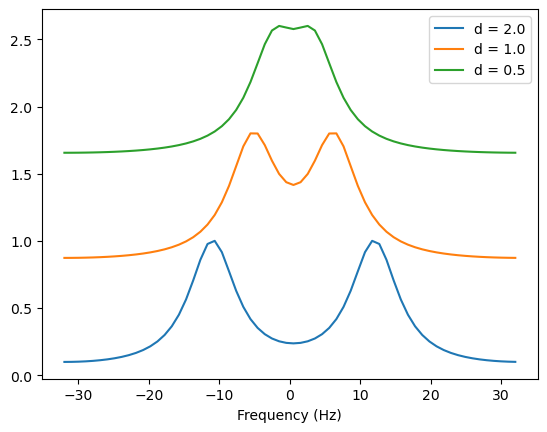

In [3]:
import fsl_mrs.utils.synthetic as syn
from fsl_mrs.core import MRS, basis
def spectrum_complex(amplitude, frequency, damping, noise=0.0, sw_factor=1.0):
    fid, hdrs = syn.syntheticFID(
                 noisecovariance=[[noise]],
                 bandwidth=spectral_width * sw_factor,
                 points=int(points * sw_factor),
                 chemicalshift=[frequency[0] / 123.2 , frequency[1] / 123.2],
                 amplitude=[amplitude[0], amplitude[1]],
                 linewidth=[damping[0], damping[1]],
                 g=[0.0, 0.0])

    # Construct basis simultaneously
    fid_basis_1, hdrs1 = syn.syntheticFID(
                 noisecovariance=[[0]],
                 bandwidth=spectral_width * sw_factor,
                 points=int(points * sw_factor),
                 chemicalshift=[frequency[0] / 123.2 , frequency[1] / 123.2],
                 amplitude=[1.0, 0.0],
                 linewidth=[1, 1],
                 g=[0.0, 0.0])
    fid_basis_2, hdrs2 = syn.syntheticFID(
                 noisecovariance=[[0]],
                 bandwidth=spectral_width * sw_factor,
                 points=int(points * sw_factor),
                 chemicalshift=[frequency[0] / 123.2 , frequency[1] / 123.2],
                 amplitude=[0.0, 1.0],
                 linewidth=[1, 1],
                 g=[0.0, 0.0])
    basis_fid = np.stack((fid_basis_1[0], fid_basis_2[0]))
    hdrs1['fwhm'] = 1.0
    hdrs2['fwhm'] = 1.0
    fitting_basis = basis.Basis(basis_fid, names=['A','B'], headers=[hdrs1, hdrs2])
    return MRS(fid[0], header=hdrs, basis=fitting_basis)

# Test by recreating Figure 2A
for idx, d_val in enumerate([2.0, 1.0, 0.5]):
    test_mrs = spectrum_complex(
        (1.0, 1.0),
        separations(d_val),
        (fwhm, fwhm))

    to_plot = test_mrs.get_spec().real / np.max(test_mrs.get_spec().real)
    plt.plot(test_mrs.frequencyAxis, to_plot + idx * 0.8, label=f'd = {d_val:0.1f}')
    plt.legend()

plt.xlabel('Frequency (Hz)')

plt.savefig('../../publication/figures/s3_fmrs_tal_separation.png', dpi=400, bbox_inches='tight')

### Temporal model

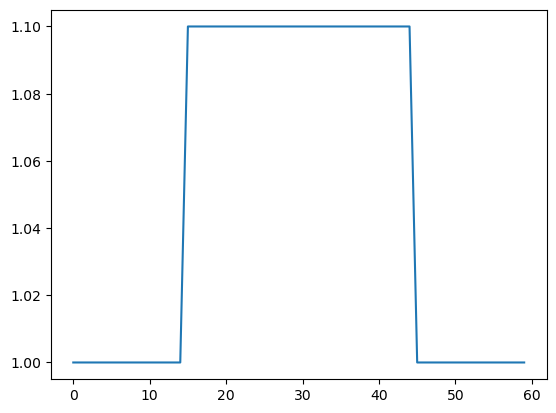

In [4]:
tr = 2
ta = 120
stim_duration = 60
stim_start = 30

nt = int(ta / tr)
stim_steps = int(stim_duration / tr)
stim_start_step = int(stim_start / tr)

def boxcar(delta):
    response = np.ones(nt)
    response[stim_start_step:(stim_start_step+stim_steps)] += delta
    return response

plt.plot(boxcar(0.1))
plt.show()

### Combined spectral-temporal data

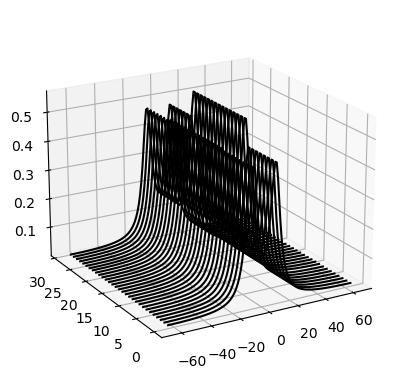

In [5]:
def gen_timeseries(delta_b, d, noise=0):
    amp_a = boxcar(0)
    amp_b = boxcar(delta_b)

    mrs_list = []
    for aa, ab in zip(amp_a, amp_b):
        mrs_list.append(
            spectrum_complex(
                (aa, ab),
                separations(d),
                (fwhm, fwhm),
                noise=noise,
                sw_factor=2.0))
    return mrs_list

mrs_list_test = gen_timeseries(0.2, 1.5)

fig = plt.figure()
ax = plt.axes(projection='3d')
for idx, mrs in enumerate(mrs_list_test[::2]):
    ax.plot3D(
        mrs.frequencyAxis.squeeze(),
        np.ones(128) * idx,
        mrs.get_spec().real,
        'k')
ax.view_init(elev=20., azim=-120)

plt.savefig('../../publication/figures/s2_fmrs_tal_timeseries.png', dpi=400, bbox_inches='tight')

## Fit
Do fit with just one setting and one rep

/Users/wclarke/opt/miniconda3/envs/fsl_mrs/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/Users/wclarke/opt/miniconda3/envs/fsl_mrs/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


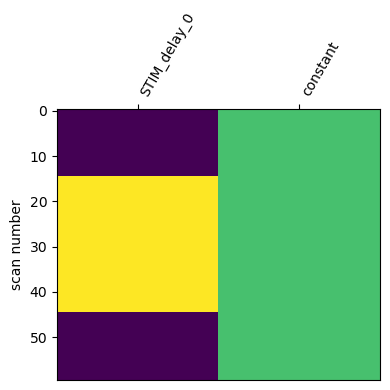

In [6]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import pandas as pd

frame_times = np.arange(60) * tr
conditions  = ['STIM',] 
duration    = [stim_duration,]
onsets = [stim_start, ] # Start time of each stimulation block.
events = pd.DataFrame({'trial_type': conditions, 
                       'onset'     : onsets,
                       'duration'  : duration})

design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    drift_model='polynomial',
    drift_order=0,
    hrf_model='fir'
)
fig = plt.figure(figsize=(4,4))
_ = plot_design_matrix(design_matrix, ax=fig.gca())

In [7]:
%%writefile dyn_model.py
from numpy import dot

# Parameter - functional relationships
Parameters = {
    'conc'     : {'dynamic': 'model_glm', 'params': [f'beta{i}' for i in range(2)]},
    'gamma'    : 'fixed',
    'eps'      : 'fixed',
    'baseline' : 'fixed',
    'Phi_0'    : 'fixed',
    'Phi_1'    : 'fixed'}

# Bounds on free fitted parameters
Bounds = {
    'gamma': (0, None),
    'beta1': (0, None)}


# Dynamic models
def model_glm(p, t):
    return dot(t, p)


# Dynamic model gradients
def model_glm_grad(p, t):
    return t.T

Overwriting dyn_model.py


/Users/wclarke/opt/miniconda3/envs/fsl_mrs/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning:

The fit may be poorly conditioned



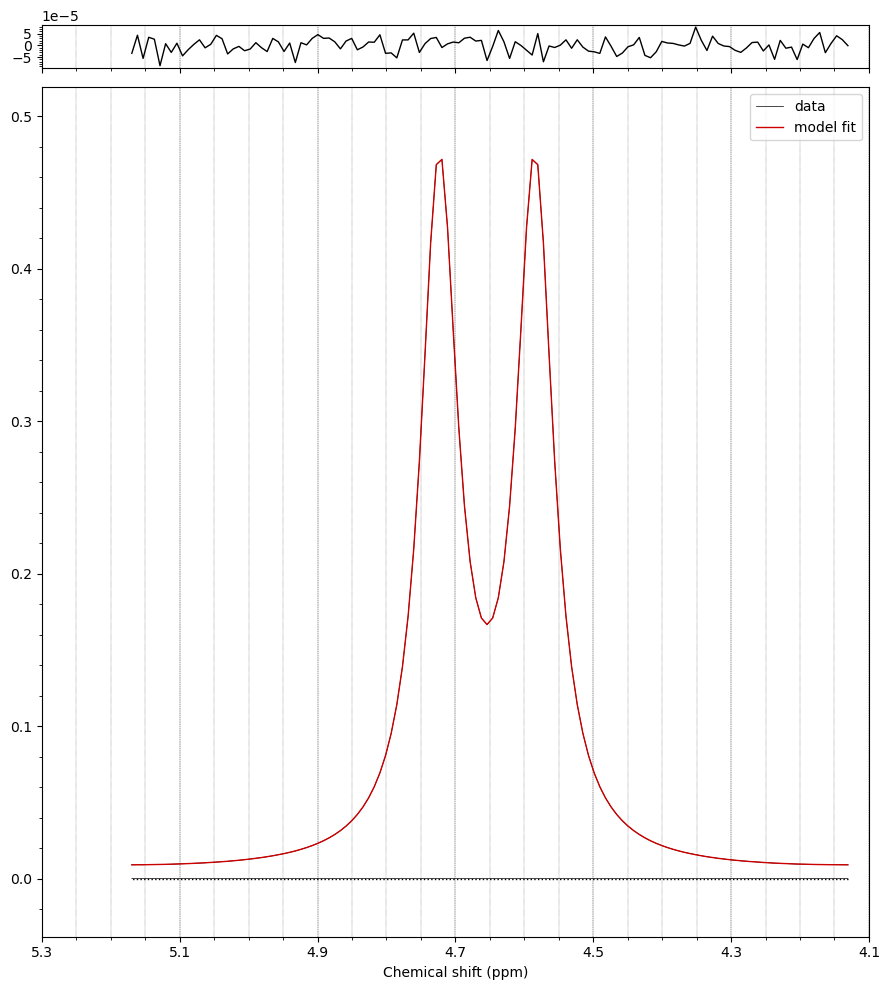

In [9]:
from fsl_mrs.utils.fitting import fit_FSLModel
from fsl_mrs.utils import plotting as fplot

mrs_list_noise = gen_timeseries(0.2, 1.5, noise=1E-9,)

Fitargs = {
    'metab_groups'   : [0, 1],
    'baseline_order' : 0,
    'ppmlim'         : (4.1, 5.2),
    'model'          : 'lorentzian'}

res_single = fit_FSLModel(mrs_list_noise[0], **Fitargs)

fplot.plot_fit(mrs_list_noise[0], res_single)
plt.show()

In [10]:
from fsl_mrs import dynamic as dyn


obj = dyn.dynMRS(
    mrs_list_noise,
    design_matrix.to_numpy(),
    'dyn_model.py',
    rescale=False,
    **Fitargs
    )

init = obj.initialise(verbose=True)
dyn_fit= obj.fit(init=init)
dyn_result = dyn_fit.mean_free
init_result = dyn_fit.init_free_dataframe
print(dyn_result.conc_B_beta0 / dyn_result.conc_B_beta1)
print(init_result.conc_B_beta0 / init_result.conc_B_beta1)



/Users/wclarke/opt/miniconda3/envs/fsl_mrs/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning:

The fit may be poorly conditioned



Init done in 8.486160039901733 seconds.
0.2000138491441481
0.19984368690219065


In [11]:
dyn_result

conc_A_beta0     0.000033
conc_A_beta1     1.187359
conc_B_beta0     0.237508
conc_B_beta1     1.187460
gamma_0         21.990136
gamma_1         21.991805
eps_0           -0.001678
eps_1           -0.002139
Phi_0_0          0.000057
Phi_1_0          0.000001
baseline_0       0.000005
baseline_1       0.000004
dtype: float64

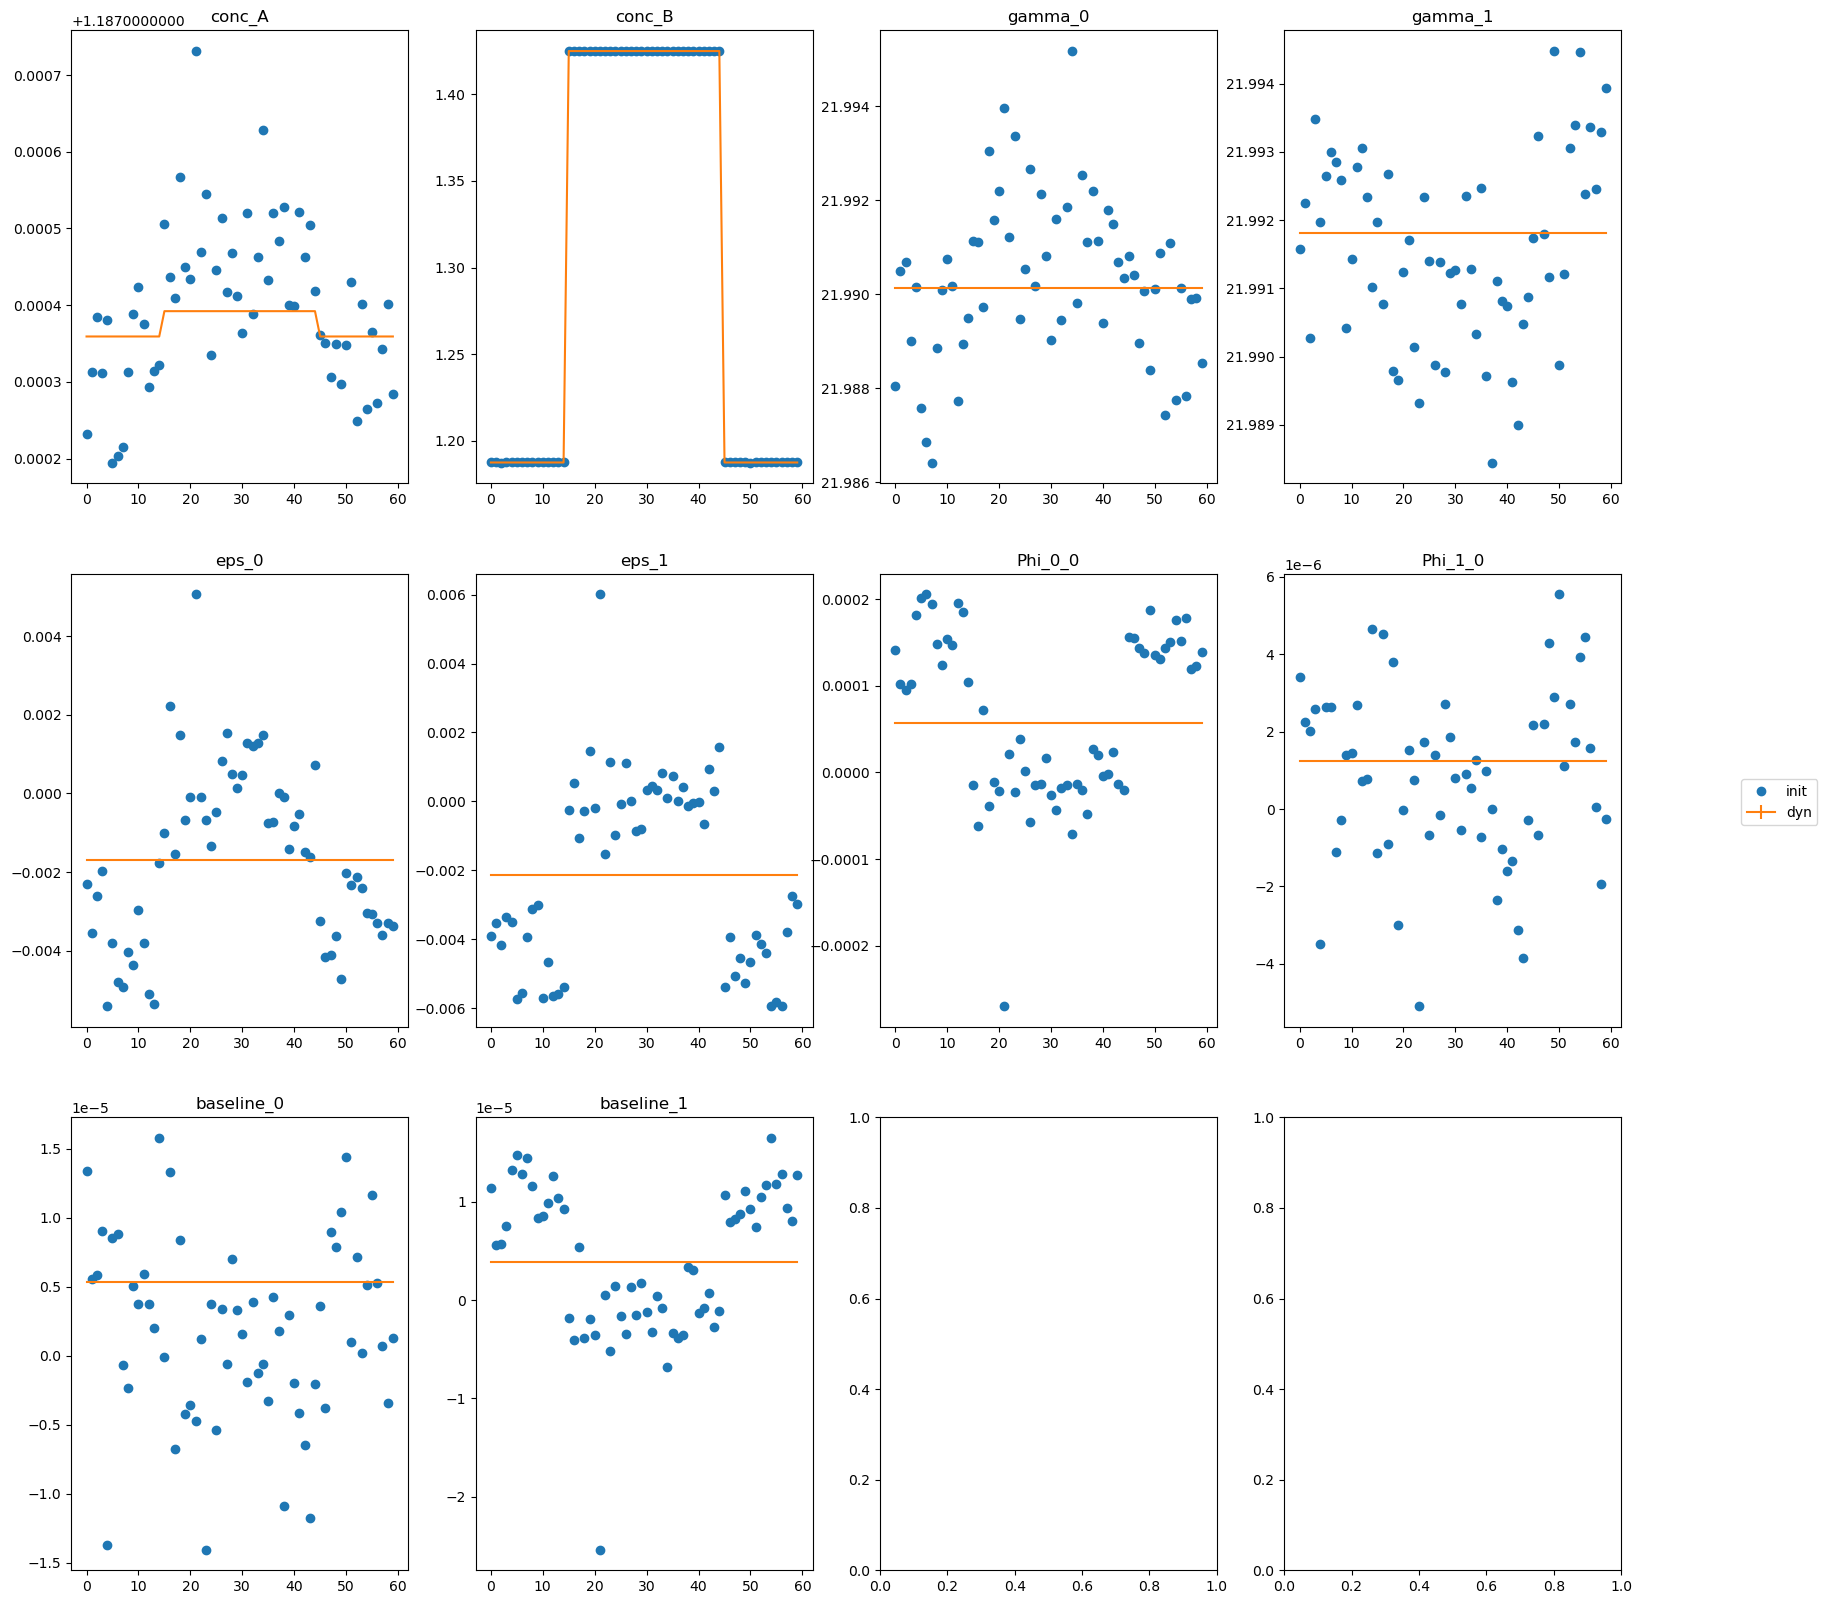

In [12]:
_ = dyn_fit.plot_mapped()